In [1]:
import pandas as pd
import subprocess
import io
from tqdm import tqdm

In [2]:
from IPython.display import display

# Setting the transport for the different markets

1. We will take the **distances** for the exports for 'each product' from 'each country' to 'each destination' from **UNCTAD data**
1. The 'tons km' introduced in our 'markets' will be a result of the weighted average of the relevant suppliers in our activity

### Data

Data was bulk-downloaded from: https://unctadstat.unctad.org/datacentre/dataviewer/US.TransportCosts

### HS labels

👓 Structure of HS2012 labels: https://unstats.un.org/unsd/classifications/Econ/Structure

For the metals, we choose all forms but those related to waste and scrap as that will be modelled in a later phase

We neglect wrought forms. As the transport for final products is expected to be modelled in ecoinvent

In [3]:
metals = {
    # Chapter 26 – Ores, slag and ash
    'stibnite': ['2617'],            # from 261710 → "2617" | Ores and concentrates,  n.e.c. in heading no. 2601
    'bauxite': ['2606'],             # from 260600 → "2606" | Aluminium ores and concentrates
    'chromite': ['2610'],            # from 261000 → "2610" | Chromium ores and concentrates
    'cobalt_ore': ['2605'],          # from 260500 → "2605" | Cobalt ores and concentrates
    'copper_ore': ['2603'],          # from 260300 → "2603" | Copper ores and concentrates
    'iron_ore': ['2601'],            # from 260111/260120 → "2601" | Iron ores and concentrates
    'lead_ore': ['2607'],            # from 260700 → "2607" | Lead ores and concentrates
    'manganese_ore': ['2602'],       # from 260200 → "2602" | Manganese ores and concentrates, including ferruginous manganese ores and concentrates with a manganese content of 20% or more, calculated on the dry weight
    'molybdenite': ['2613'],         # from 261310/261390 → "2613" | Molybdenum ores and concentrates
    'nickel_ore': ['2604'],          # from 260400 → "2604" | Nickel ores and concentrates
    'phosphate_rock': ['2510'],      # from 251010/251020 → "2510" | Natural calcium phosphates
    'silver_ore': ['2616'],          # from 261610 → "2616" | Precious metal ores and concentrates
    'tantalum_vanadium_niobium_ore': ['2615'], # # from 261590 → "2615" | Niobium, tantalum, vanadium or zirconium ores and concentrates
    'tin_ore': ['2609'],             # from 260900 → "2609" | Tin ores and concentrates
    'titanium_ore': ['2614'],        # from 261400 → "2614" | Titanium ores and concentrates
    'tungsten_ore': ['2611'],        # from 261100 → "2611" | Tungsten ores and concentrates
    'uranium_ore': ['2612'],         # from 261210 → "2612" | Uranium or thorium ores and concentrates
    'zinc_ore': ['2608'],            # from 260800 → "2608" | Zinc ores and concentrates

    # Chapter 28 – Inorganic chemicals (relevant to metals)
    'aluminium_hydroxide': ['2818'], # from 281830 → "2818" | Aluminium oxide (including artificial corundum), aluminium hydroxide
    'aluminium_oxide': ['2818'],     # from 281820 → "2818" | Aluminium oxide (including artificial corundum), aluminium hydroxide
    'other_hydroxide': ['2825'],      # from 282590 → "2825" | Hydrazine and hydroxylamine and their inorganic salts,  other inorganic bases,  other metal oxides, hydroxides and peroxides
    'other_borate': ['2840'],         # from 284020 → "2840" | Borates, peroxoborates (perborates)
    'sodium_borate': ['2840'],        # from 284019 → "2840" | Borates, peroxoborates (perborates)
    'boric_oxid_acid': ['2810'],      # from 281000 → "2810" | Oxides of boron,  boric acids
    'cobalt_hydroxide': ['2822'],     # from 282200 → "2822" | Cobalt oxides and hydroxides, commercial cobalt oxides
    'other_sulfate': ['2833'],        # from 283329 → "2833" | Sulphates, alums,  peroxosulphates (persulphates)
    'phosphorous': ['2804'],          # from 280470 → "2804" | Hydrogen, rare gases and other non-metals, 
    'phosphoric_acid': ['2809'],      # from 280920 → "2809" | Diphosphorus pentoxide,  phosphoric acid and polyphosphoric acids
    'potash': ['2815'],              # from 281520 → "2815" | Sodium hydroxide (caustic soda), m hydroxide (caustic potash) peroxides of sodium or potassium
    'reo_scandium_yttrium': ['2805'], # from 280530 → "2805" | Alkali or alkaline-earth metals,  rare-earth metals, scandium and yttrium, whether or not intermixed or interalloyed, mercury
    'selenium': ['2804'],            # from 280490 → "2804" | Hydrogen, rare gases and other non-metals, 
    'sulfur': ['2802'],              # from 280200 → "2802" | Sulphur, sublimed or precipitated, colloidal sulphur
    'vanadium_oxide': ['2825'],      # from 282530 → "2825" | Hydrazine and hydroxylamine and their inorganic salts,  other metal oxides, hydroxides and peroxides
    'lithium_hydroxide': ['2825'],   # from 282520 → "2825" | Hydrazine and hydroxylamine and their inorganic salts,  other metal oxides, hydroxides and peroxides
    'other_chloride': ['2827'],      # from 282739 → "2827" | Chlorides,  chloride oxides and chloride hydroxides,  bromides and bromide oxides,  iodides and iodide oxides, 
    'lithium_carbonate': ['2836'],   # from 283691 → "2836" | Carbonates,  peroxocarbonates (percarbonates),  commercial ammonium carbonate containing ammonium carbamate, 
    'other_carbonate': ['2836'],     # from 283699 → "2836" | Carbonates,  peroxocarbonates (percarbonates),  commercial ammonium carbonate containing ammonium carbamate, 
    'other_carbide': ['2849'],       # from 284990 → "2849" | Carbides, whether or not chemically defined
    'other_fluoride': ['2826'],      # from 282619/282690 → "2826" | Fluorides,  fluorosilicates, fluoroaluminates and other complex fluorine salts
    'silicon': ['2804'],             # from 280461 → "2804" | Hydrogen, rare gases and other non-metals, 

    # Metals (primary metal products, not just ores)
    'antimony': ['8110'],            # from 811010 → "8110" | Antimony, articles thereof, including waste and scrap
    'aluminium': ['7601'],           # from 760110 → "7601" | Aluminium, unwrought
    'aluminium_cast_alloy': ['7601'],# from 760120 → "7601" | Aluminium, unwrought
    'bentonite': ['2508'],           # from 250810 → "2508" | Clays, mullite, chamotte or dinas earth
    'beryllium': ['8112'],           # from 811212 → "8112" | Beryllium, chromium, germanium, vanadium, gallium, hafnium, indium, niobium (columbium), rhenium and thallium
    'boron_tellurium': ['2804'],      # from 280450 → "2804" | Hydrogen, rare gases and other non-metals
    'cadmium': ['8107'],             # from 810720 → "8107" | Cadmium, articles thereof, including waste and scrap
    'chromium': ['8112'],            # from 811221 → "8112" | Beryllium, chromium, germanium, vanadium, gallium, hafnium, indium, niobium (columbium), rhenium and thallium, and articles of these metals, including waste and scrap
    'cobalt': ['8105'],              # from 810520 → "8105" | Cobalt,  mattes and other intermediate products of cobalt metallurgy, cobalt and articles thereof, including waste and scrap
    'copper_anode': ['7402'],        # from 740200 → "7402" | Copper, unrefined, copper anodes for electrolytic refining
    'copper_cathode': ['7403'],      # from 740311 → "7403" | Copper, refined and copper alloys, unwrought
    'ga_ge_hf_in_nb_rh_va': ['8112'],  # from 811292 → "8112" | Beryllium, chromium, germanium, vanadium, gallium, hafnium, indium, niobium (columbium), rhenium and thallium, and articles of these metals, including waste and scrap
    'gold': ['7108'],                # from 710811/710812 → "7108" | Gold (including gold plated with platinum) unwrought or in semi-manufactured forms, or in powder form
    'graphite': ['2504'],            # from 250410/250490 → "2504" | Graphite, natural
    'pgm': ['7110'],                 # from 711041 → "7110" | Platinum, unwrought or in semi-manufactured forms, or in powder form
    'pig_iron': ['7201'],            # from 720110/720120/720150 → "7201" | Pig iron and spiegeleisen in pigs, blocks or other primary forms
    'lead': ['7801'],                # from 780110/780191/780199 → "7801" | Lead, unwrought
    'dolomite': ['2518'],            # from 251810/251820/251830 → "2518" | Dolomite, whether or not calcined or sintered, including dolomite roughly trimmed, or merely cut by sawing or otherwise into blocks or slabs of rectangular (including square) shape, dolomite ramming mix
    'magnesium': ['8104'],           # from 810411/810419 → "8104" | Magnesium, articles thereof, including waste and scrap
    'manganese': ['8111'],           # from 811100 → "8111" | Manganese, articles thereof, including waste and scrap
    'molybdenum': ['8102'],          # from 810294 → "8102" | Molybdenum, articles thereof, including waste and scrap
    'nickel': ['7502'],              # from 750210 → "7502" | Nickel, unwrought
    'niobium': ['7202'],             # from 720293 → "7202" | Ferro-alloys
    'palladium': ['7110'],           # from 711021 → "7110" | Platinum, unwrought or in semi-manufactured forms, or in powder form
    'platinum': ['7110'],            # from 711011 → "7110" | Platinum, unwrought or in semi-manufactured forms, or in powder form
    'silica_sand': ['2505'],         # from 250510 → "2505" | Sands of all kinds, natural, whether or not coloured, other than metal-bearing sands of chapter 26
    'tin': ['8001'],                 # from 800110 → "8001" | Tin, unwrought
    'titanium': ['8108'],            # from 810820 → "8108" | Titanium, articles thereof, including waste and scrap
    'zinc': ['7901'],                # from 790111/790112 → "7901" | Zinc, unwrought
    'zirconium': ['8109']            # from 810920 → "8109" | Zirconium, articles thereof, including waste and scrap
}


# Explore data

In [4]:
seven_zip = r"C:\Program Files\7-Zip\7z.exe"
cmd = [seven_zip, "x", "-so", "US_TransportCosts_20212021.csv.7z"]
proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
text_stream = io.TextIOWrapper(proc.stdout, encoding='utf-8')

In [5]:
df = pd.read_csv(text_stream, nrows=5)
display(df)

,Year,Origin,Origin Label,Destination,Destination Label,Product,Product Label,TransportMode,TransportMode Label,FOB value (US$),...,Transport cost intensity in US$ per 1000 $-km Missing value,Kilograms,Kilograms Footnote,Kilograms Missing value,Ad-valorem freight rate,Ad-valorem freight rate Footnote,Ad-valorem freight rate Missing value,Unit value (US$/kg),Unit value (US$/kg) Footnote,Unit value (US$/kg) Missing value
0,2021,4,Afghanistan,4,Afghanistan,TOTAL,Total of all commodities,80,Multimodal adjustment,NaN,...,Not applicable,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported
1,2021,4,Afghanistan,4,Afghanistan,01,Animals; live,80,Multimodal adjustment,NaN,...,Not applicable,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported
2,2021,4,Afghanistan,4,Afghanistan,0101,"Horses, asses, mules and hinnies; live",80,Multimodal adjustment,NaN,...,Not applicable,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported
3,2021,4,Afghanistan,4,Afghanistan,0102,Bovine animals; live,80,Multimodal adjustment,NaN,...,Not applicable,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported
4,2021,4,Afghanistan,4,Afghanistan,0103,Swine; live,80,Multimodal adjustment,NaN,...,Not applicable,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported,NaN,NaN,Not available or not separately reported


### Exploring unique "Product" codes

In [6]:
chunksize = 100_000
product_code_label_pairs = pd.DataFrame()

In [7]:
seven_zip = r"C:\Program Files\7-Zip\7z.exe"
cmd = [seven_zip, "x", "-so", "US_TransportCosts_20212021.csv.7z"]

In [8]:
preview_proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
preview_stream = io.TextIOWrapper(preview_proc.stdout, encoding='utf-8')
preview_df = pd.read_csv(preview_stream, nrows=5)
columns = preview_df.columns.tolist()
preview_proc.stdout.close()
preview_proc.wait()

print("✅ Columns detected:")
print(columns)

✅ Columns detected:
['Year', 'Origin', 'Origin Label', 'Destination', 'Destination Label', 'Product', 'Product Label', 'TransportMode', 'TransportMode Label', 'FOB value (US$)', 'FOB value (US$) Footnote', 'FOB value (US$) Missing value', 'Transport expenditure (US$)', 'Transport expenditure (US$) Footnote', 'Transport expenditure (US$) Missing value', 'Per-unit freight rate (US$/kg)', 'Per-unit freight rate (US$/kg) Footnote', 'Per-unit freight rate (US$/kg) Missing value', 'Transport work in ton-km', 'Transport work in ton-km Footnote', 'Transport work in ton-km Missing value', 'Transport work in 1000 $-km', 'Transport work in 1000 $-km Footnote', 'Transport work in 1000 $-km Missing value', 'Transport cost intensity in US$ per ton-km', 'Transport cost intensity in US$ per ton-km Footnote', 'Transport cost intensity in US$ per ton-km Missing value', 'Transport cost intensity in US$ per 1000 $-km', 'Transport cost intensity in US$ per 1000 $-km Footnote', 'Transport cost intensity in 

In [10]:
proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
text_stream = io.TextIOWrapper(proc.stdout, encoding='utf-8')

for chunk in tqdm(pd.read_csv(text_stream, chunksize=chunksize, names=columns, header=0, low_memory=False), desc="Reading chunks"):
    if "Product" in chunk.columns and "Product Label" in chunk.columns:
        pairs = chunk[["Product", "Product Label"]].drop_duplicates()
        product_code_label_pairs = pd.concat([product_code_label_pairs, pairs], ignore_index=True)

proc.stdout.close()
proc.wait()

# Final cleanup and export
product_code_label_pairs = product_code_label_pairs.drop_duplicates().sort_values("Product")
product_code_label_pairs.to_csv("explored_product_codes_2021.csv", index=False)

print("\n✅ Done! Product codes saved to 'explored_product_codes_2021.csv'")

Reading chunks: 2240it [31:17,  1.19it/s]



✅ Done! Product codes saved to 'explored_product_codes_2021.csv'


# Filter data

In [4]:
files = [
    "US_TransportCosts_20212021.csv.7z",
    "US_TransportCosts_20202020.csv.7z",
    "US_TransportCosts_20192019.csv.7z",
    "US_TransportCosts_20182018.csv.7z",
    "US_TransportCosts_20172017.csv.7z",
    "US_TransportCosts_20162016.csv.7z",
]

In [5]:
output_file = "filtered_metals_UNCTAD.csv"
first_file = True  
chunksize = 100_000  # We can adjust this number based on your available memory

In [6]:
seven_zip = r"C:\Program Files\7-Zip\7z.exe"

In [7]:
metal_codes = [str(code) for codes in metals.values() for code in codes]

In [8]:
showed_columns = False
matched_any_rows = False

for file in files:
    print(f"\n🔄 Processing file: {file}")
    cmd = [seven_zip, "x", "-so", file]
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)

    text_stream = io.TextIOWrapper(proc.stdout, encoding="utf-8")

    try:
        for chunk in tqdm(pd.read_csv(text_stream, chunksize=chunksize, low_memory=False), desc=f"Chunks from {file}"):
            if not showed_columns:
                showed_columns = True

            valid_modes = ["Air", "Railway", "Road", "Sea"]
            transport_mode_clean = chunk["TransportMode Label"].fillna("").astype(str).str.strip()
            mode_match = transport_mode_clean.apply(lambda x: x in valid_modes)

            product_match = chunk["Product"].astype(str).isin(metal_codes)

            filtered_chunk = chunk[product_match & mode_match]
            

            if not filtered_chunk.empty:
                matched_any_rows = True
                filtered_chunk.to_csv(
                    output_file,
                    mode="w" if first_file else "a",
                    header=first_file,
                    index=False,
                    sep="\t",
                    lineterminator="\n"
                )
                first_file = False
    except Exception as e:
        print(f"❌ Error processing file {file}: {e}")

    proc.stdout.close()
    proc.wait()

if not matched_any_rows:
    print("⚠️ No matching rows found in any file. The output file was not created.")
else:
    print(f"\n✅ Processing complete. Filtered data saved to: {output_file}")



🔄 Processing file: US_TransportCosts_20212021.csv.7z


Chunks from US_TransportCosts_20212021.csv.7z: 2240it [34:08,  1.09it/s]



🔄 Processing file: US_TransportCosts_20202020.csv.7z


Chunks from US_TransportCosts_20202020.csv.7z: 2169it [32:08,  1.12it/s]



🔄 Processing file: US_TransportCosts_20192019.csv.7z


Chunks from US_TransportCosts_20192019.csv.7z: 2170it [32:32,  1.11it/s]



🔄 Processing file: US_TransportCosts_20182018.csv.7z


Chunks from US_TransportCosts_20182018.csv.7z: 2148it [32:13,  1.11it/s]



🔄 Processing file: US_TransportCosts_20172017.csv.7z


Chunks from US_TransportCosts_20172017.csv.7z: 2131it [31:57,  1.11it/s]



🔄 Processing file: US_TransportCosts_20162016.csv.7z


Chunks from US_TransportCosts_20162016.csv.7z: 2184it [32:47,  1.11it/s]


✅ Processing complete. Filtered data saved to: filtered_metals_UNCTAD.csv


In [43]:
pd.set_option('display.max_columns', None)       # Show all columns
pd.set_option('display.width', 0)                # Don't truncate to fixed width
pd.set_option('display.max_colwidth', None)      # Show full cell contents

df = pd.read_csv('filtered_metals_UNCTAD.csv', sep="\t")
display(df.head())

C:\Users\hahnme_a\AppData\Local\Temp\ipykernel_15424\4263429261.py:5: DtypeWarning: Columns (17,26,29,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('filtered_metals_UNCTAD.csv', sep="\t")


,Year,Origin,Origin Label,Destination,Destination Label,Product,Product Label,TransportMode,TransportMode Label,FOB value (US$),FOB value (US$) Footnote,FOB value (US$) Missing value,Transport expenditure (US$),Transport expenditure (US$) Footnote,Transport expenditure (US$) Missing value,Per-unit freight rate (US$/kg),Per-unit freight rate (US$/kg) Footnote,Per-unit freight rate (US$/kg) Missing value,Transport work in ton-km,Transport work in ton-km Footnote,Transport work in ton-km Missing value,Transport work in 1000 $-km,Transport work in 1000 $-km Footnote,Transport work in 1000 $-km Missing value,Transport cost intensity in US$ per ton-km,Transport cost intensity in US$ per ton-km Footnote,Transport cost intensity in US$ per ton-km Missing value,Transport cost intensity in US$ per 1000 $-km,Transport cost intensity in US$ per 1000 $-km Footnote,Transport cost intensity in US$ per 1000 $-km Missing value,Kilograms,Kilograms Footnote,Kilograms Missing value,Ad-valorem freight rate,Ad-valorem freight rate Footnote,Ad-valorem freight rate Missing value,Unit value (US$/kg),Unit value (US$/kg) Footnote,Unit value (US$/kg) Missing value
0,2021,4,Afghanistan,356,India,2836,Carbonates; peroxocarbonates (percarbonates); commercial ammonium carbonate containing ammonium carbamate,10,Air,954.792,Experimental,NaN,1022.727,Experimental,NaN,7.129702,Experimental,NaN,382.190,Experimental,NaN,2543.900,Experimental,NaN,2.675962,Experimental,NaN,0.402031,Experimental,NaN,143.446,Experimental,NaN,1.071152,Experimental,NaN,6.656106,Experimental,NaN
1,2021,4,Afghanistan,356,India,2836,Carbonates; peroxocarbonates (percarbonates); commercial ammonium carbonate containing ammonium carbamate,21,Sea,45146.832,Experimental,NaN,10748.521,Experimental,NaN,0.096257,Experimental,NaN,604979.072,Experimental,NaN,244597.150,Experimental,NaN,0.017767,Experimental,NaN,0.043944,Experimental,NaN,111664.787,Experimental,NaN,0.238079,Experimental,NaN,0.404307,Experimental,NaN
2,2021,4,Afghanistan,356,India,2836,Carbonates; peroxocarbonates (percarbonates); commercial ammonium carbonate containing ammonium carbamate,31,Railway,8573.539,Experimental,NaN,202.934,Experimental,NaN,0.008958,Experimental,NaN,49588.214,Experimental,NaN,18784.583,Experimental,NaN,0.004092,Experimental,NaN,0.010803,Experimental,NaN,22652.834,Experimental,NaN,0.023670,Experimental,NaN,0.378475,Experimental,NaN
3,2021,4,Afghanistan,356,India,2836,Carbonates; peroxocarbonates (percarbonates); commercial ammonium carbonate containing ammonium carbamate,32,Road,33662.451,Experimental,NaN,2687.591,Experimental,NaN,0.032905,Experimental,NaN,146519.038,Experimental,NaN,62166.722,Experimental,NaN,0.018343,Experimental,NaN,0.043232,Experimental,NaN,81676.423,Experimental,NaN,0.079839,Experimental,NaN,0.412144,Experimental,NaN
4,2021,4,Afghanistan,364,Iran (Islamic Republic of),2608,Zinc ores and concentrates,10,Air,775.069,Experimental,NaN,19927.192,Experimental,NaN,85.462773,Experimental,NaN,540.212,Experimental,NaN,1795.706,Experimental,NaN,36.887747,Experimental,NaN,11.097135,Experimental,NaN,233.168,Experimental,NaN,25.710216,Experimental,NaN,3.324078,Experimental,NaN


# Weighted average

- Transport work (ton‑km) = (Weight in tons) × (Distance in km)
- Weight in tons = Kilograms ÷ 1000
- Distance = (Transport work in ton‑km × 1000) ÷ Kilograms

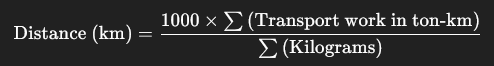

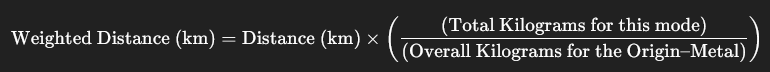

In [44]:
# Map product codes to metal names.
metal_lookup = {str(code): metal for metal, codes in metals.items() for code in codes}
df["Metal"] = df["Product"].astype(str).map(metal_lookup)
df = df.dropna(subset=["Metal"])

In [45]:
# Ensure numeric columns are correctly typed.
df["Transport work in ton-km"] = pd.to_numeric(df["Transport work in ton-km"], errors="coerce")
df["Kilograms"] = pd.to_numeric(df["Kilograms"], errors="coerce")
df = df.dropna(subset=["Transport work in ton-km", "Kilograms"])

In [46]:
grouped = df.groupby(["Origin Label", "Metal", "TransportMode Label"]).agg(
    total_work_in_ton_km = ("Transport work in ton-km", "sum"),
    total_kg   = ("Kilograms", "sum")
).reset_index()

grouped["Distance (km)"] = 1000 * grouped["total_work_in_ton_km"] / grouped["total_kg"]

In [47]:
overall = grouped.groupby(["Origin Label", "Metal"]).agg(
    overall_kg = ("total_kg", "sum")
).reset_index()

In [48]:
merged = pd.merge(grouped, overall, on=["Origin Label", "Metal"], how="left")

merged["Fraction"] = merged["total_kg"] / merged["overall_kg"]
merged["Weighted Distance (km)"] = merged["Distance (km)"] * merged["Fraction"]

In [49]:
output = merged[[
    "Origin Label", "Metal", "TransportMode Label",
    "total_work_in_ton_km", "total_kg", "Distance (km)", "Weighted Distance (km)"
]].sort_values(["Origin Label", "Metal", "TransportMode Label"])

In [50]:
print(output.head(10))

  Origin Label                 Metal TransportMode Label  \
0  Afghanistan  aluminium_cast_alloy                 Air   
1  Afghanistan  aluminium_cast_alloy             Railway   
2  Afghanistan  aluminium_cast_alloy                Road   
3  Afghanistan  aluminium_cast_alloy                 Sea   
4  Afghanistan       aluminium_oxide                 Air   
5  Afghanistan       aluminium_oxide             Railway   
6  Afghanistan       aluminium_oxide                Road   
7  Afghanistan       aluminium_oxide                 Sea   
8  Afghanistan             bentonite                 Air   
9  Afghanistan             bentonite             Railway   

   total_work_in_ton_km     total_kg  Distance (km)  Weighted Distance (km)  
0          2.786550e+02      129.549    2150.962184                0.028461  
1          2.023848e+05    38010.323    5324.470302               20.670751  
2          1.228904e+07  3188327.389    3854.385318             1255.151982  
3          5.877101e+07  65

In [51]:
output.to_csv("transport_markets_data.csv", index=False)
print("✅ Aggregated data saved to 'transport_markets_data.csv'")

✅ Aggregated data saved to 'transport_markets_data.csv'
